## Imports and set data path

In [1]:
# Imports
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from scipy.stats import gaussian_kde
import math
import rounders

# Set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=sys.maxsize)
alt.data_transformers.disable_max_rows()


# Set data path here
data_path = 'airfoil_9k_data.h5'


## Explore contents and architecture of .h5 data file

`Data Structure` <br>
The .h5 data file is structured as follows: <br>

|-- root (group, 3 members) <br>
 &emsp;&emsp;	|-- alpha+04 (group, 3 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- C_d (dataset, shape(8997,)) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- C_l (dataset, shape(8997,)) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- C_m (dataset, shape(8997,)) <br>
 &emsp;&emsp;	|-- alpha+12 (group, 3 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- C_d (dataset, shape(8997,)) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- C_l (dataset, shape(8997,)) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- C_m (dataset, shape(8997,)) <br>
 &emsp;&emsp;	|-- shape (group, 4 members) <br>
 &emsp;&emsp;	&emsp;&emsp;	|-- bezier (dataset, shape(8997,15)) <br>
 &emsp;&emsp;	&emsp;&emsp;	|-- cst (dataset, shape(8997,19)) <br>
 &emsp;&emsp;	&emsp;&emsp;	|-- landmarks (dataset, shape(8997,1001,2)) <br>
 &emsp;&emsp;	&emsp;&emsp;	|-- pga (dataset, shape(8997,4)) <br>



In [2]:
# Open file and print the top level group names/keys
# This data set contains 8997 unique airfoil shapes
# The alpha+XX groups represents the airfoil angle of attack (4 and 12 degrees) and contain datasets for the coeffients of drag, lift, and moment
# The shape group contains 4 datasets representing the different parameterizations of the airfoil geometries.
with h5py.File(data_path, 'r') as hf:
    top_groups = [k for k in hf.keys()]
    print(top_groups)


['alpha+04', 'alpha+12', 'shape']


In [3]:
# Explore contents of the three top level groups

# Each alpha+XX group contains 3 members:
#   C_d: dataset, (8997,) array representing the coeffients of drag for each airfoil geometry at the specified angle of attack
#   C_l: dataset, (8997,) array representing the coeffients of lift for each airfoil geometry at the specified angle of attack
#   C_m: dataset, (8997,) array representing the coeffients of moment for each airfoil geometry at the specified angle of attack
# The shape group contains 4 members representing different paramerizations of the airfoil geometry:
#   bezier:     dataset (8997,15) NumPy array representing the goemetries of each airfoil via a Bezier Curve
#   cst:        dataset (8997,19) NumPy array representing the geometries of each airfoil via Class-Shape Transformation.
#   grassmann:  dataset (8997,4) NumPy array representing the geometries of each airfoil via Grassmann.
#   landmarks:  dataset (8997,1001,2) NumPy array representing the geometries of each airfoil via (x, y) landmarks.

with h5py.File(data_path, 'r') as hf:
    for name in top_groups:
        print('-------------------------------------------------')
        print('Group Name:', name)
        print('Group Info:', hf[name])
        print('')
        
        if 'alpha' in name:
            print('Aerodynamic quantities:')
            for key in hf[name].keys():
                print(hf[name][key])
        else:
            print('Airfoil shape data:')
            for key in hf[name].keys():
                print(hf[name][key])
    print('-------------------------------------------------')
    

-------------------------------------------------
Group Name: alpha+04
Group Info: <HDF5 group "/alpha+04" (3 members)>

Aerodynamic quantities:
<HDF5 dataset "C_d": shape (8997,), type "<f8">
<HDF5 dataset "C_l": shape (8997,), type "<f8">
<HDF5 dataset "C_m": shape (8997,), type "<f8">
-------------------------------------------------
Group Name: alpha+12
Group Info: <HDF5 group "/alpha+12" (3 members)>

Aerodynamic quantities:
<HDF5 dataset "C_d": shape (8997,), type "<f8">
<HDF5 dataset "C_l": shape (8997,), type "<f8">
<HDF5 dataset "C_m": shape (8997,), type "<f8">
-------------------------------------------------
Group Name: shape
Group Info: <HDF5 group "/shape" (4 members)>

Airfoil shape data:
<HDF5 dataset "bezier": shape (8997, 15), type "<f8">
<HDF5 dataset "cst": shape (8997, 19), type "<f8">
<HDF5 dataset "grassmann": shape (8997, 4), type "<f8">
<HDF5 dataset "landmarks": shape (8997, 1001, 2), type "<f8">
-------------------------------------------------


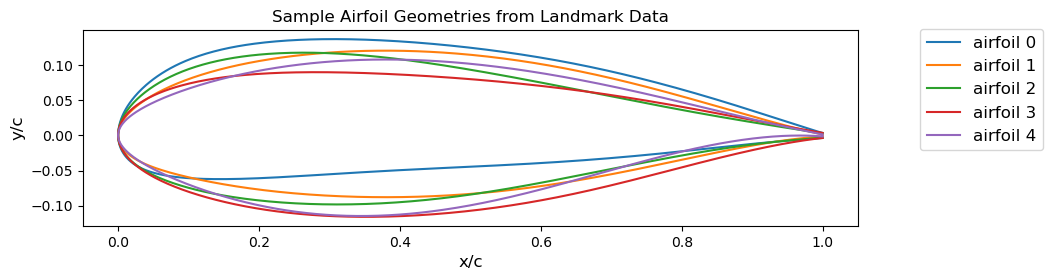

In [20]:
# Visualize the first 5 airfoil geometries using the landmarks dataset
plt.figure(figsize=(10, 6))
with h5py.File(data_path, 'r') as hf:
    landmarks = hf['shape']['landmarks'][()]
    af_shape_count = 0
    for landmark in landmarks[0:5]:
        plt.plot(landmark[:, 0], landmark[:, 1], label='airfoil {}'.format(af_shape_count))
        af_shape_count += 1
plt.xlabel('x/c', fontsize=12)
plt.ylabel('y/c', fontsize=12)
plt.gca().set_aspect(1.)
plt.legend(bbox_to_anchor=(1.25, 1.05), fontsize=12)
plt.title('Sample Airfoil Geometries from Landmark Data')
plt.show()

In [5]:
# Parse the landmark datasets and extract thickness along the chord and camber line
with h5py.File(data_path, 'r') as hf:
    landmarks = hf['shape']['landmarks'][()]
    # Calculate thickness at each x_c step except for the leading edge (x_c~0.0, index 500, axis=1)
    thickness_arr_2d = abs(landmarks[:,501:,1] - np.flip(landmarks[:,:500,1],axis=1))
    # Calculate camber / midpoint at each x_c step
    camber_arr_2d = (landmarks[:,501:,1] + np.flip(landmarks[:,:500,1],axis=1))/2
    # Create numpy array to represent x_c values at each thickness/camber step (0.002 increments between 0.002 and 1.0 inclusive)
    x_c_arr = np.resize(np.arange(0.002,1.002,0.002), thickness_arr_2d.shape[0]*500)

    # Reshape thickness array such that each row is one thickness value totaling 8997 airfoils * 500 landmarks per foil, output shape = (4498500,1)
    thickness_arr_1d = np.reshape(thickness_arr_2d, (8997*500,1))
    # Insert x_c value indexes in 0th column --> output shape = (4498500,2) 
    thickness_arr_1d = np.insert(thickness_arr_1d, 0, x_c_arr, axis=1)

    # Reshape camber array such that each row is one camber value totaling 8997 airfoils * 500 landmarks per foil (4498500,1)
    camber_arr_1d = np.reshape(camber_arr_2d, (8997*500,1))
    # Insert x_c value indexes in first 0th column --> (4498500,2) output
    camber_arr_1d = np.insert(camber_arr_1d, 0, x_c_arr, axis=1)


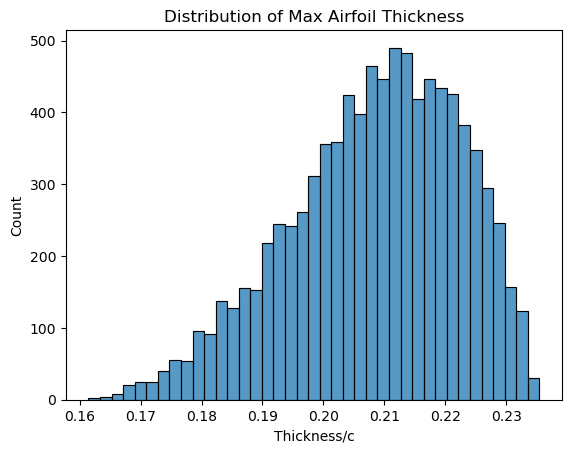

In [6]:
# Visualize distribution of maximum thickness across airfoils
ax = sns.histplot(data=np.max(thickness_arr_2d, axis=1), stat='count')
ax.set_title('Distribution of Max Airfoil Thickness')
ax.set(xlabel='Thickness/c');

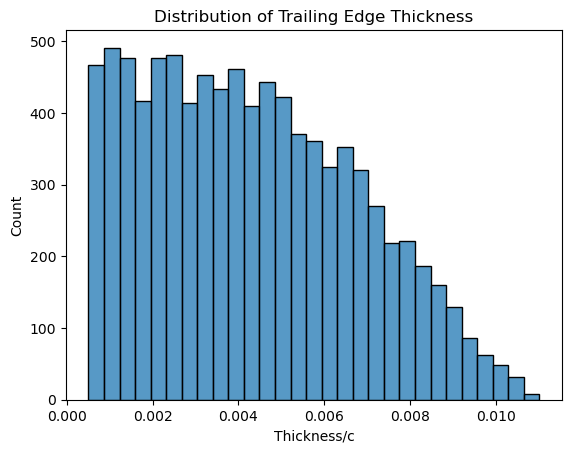

In [7]:
# Visualize distribution of trailing edge thickness
ax = sns.histplot(data=thickness_arr_2d[:,499], stat='count')
ax.set_title('Distribution of Trailing Edge Thickness')
ax.set(xlabel='Thickness/c');

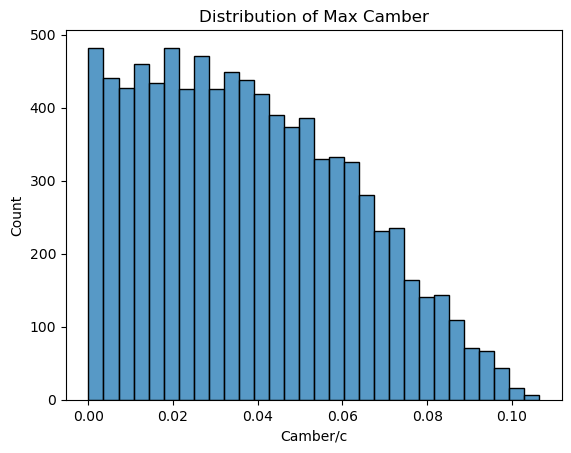

In [8]:
# Visualize distribution of maximum camber across airfoils
ax = sns.histplot(data=np.max(camber_arr_2d, axis=1), stat='count')
ax.set_title('Distribution of Max Camber')
ax.set(xlabel='Camber/c');

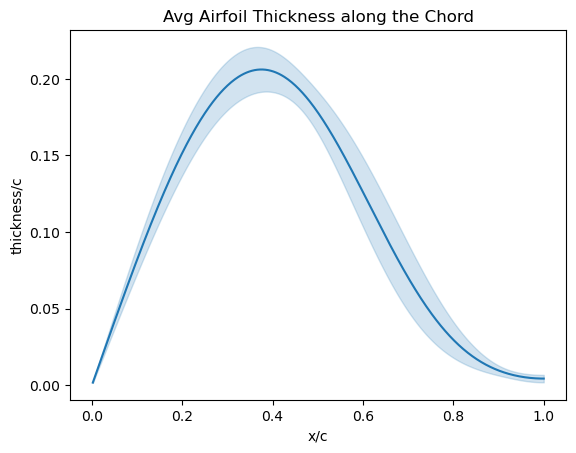

In [9]:
# Visualize average thickness along the chord and standard deviation across all airfoils
ax = sns.lineplot(data=thickness_arr_1d, x=thickness_arr_1d[:,0], y=thickness_arr_1d[:,1], errorbar='sd', n_boot=(len(thickness_arr_1d)))
ax.set(xlabel='x/c', ylabel='thickness/c')
ax.set_title('Avg Airfoil Thickness along the Chord');

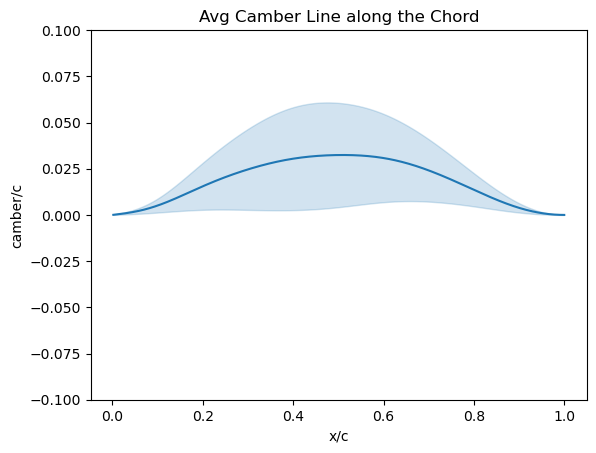

In [10]:
# Visualization of Average Camber line and standard deviation across all airfoils
ax = sns.lineplot(data=camber_arr_1d, x=camber_arr_1d[:,0], y=camber_arr_1d[:,1], errorbar='sd', n_boot=(len(camber_arr_1d)))
ax.set(xlabel='x/c', ylabel='camber/c')
ax.set_title('Avg Camber Line along the Chord')
ax.set_ylim(ymin=-0.10, ymax=0.10);

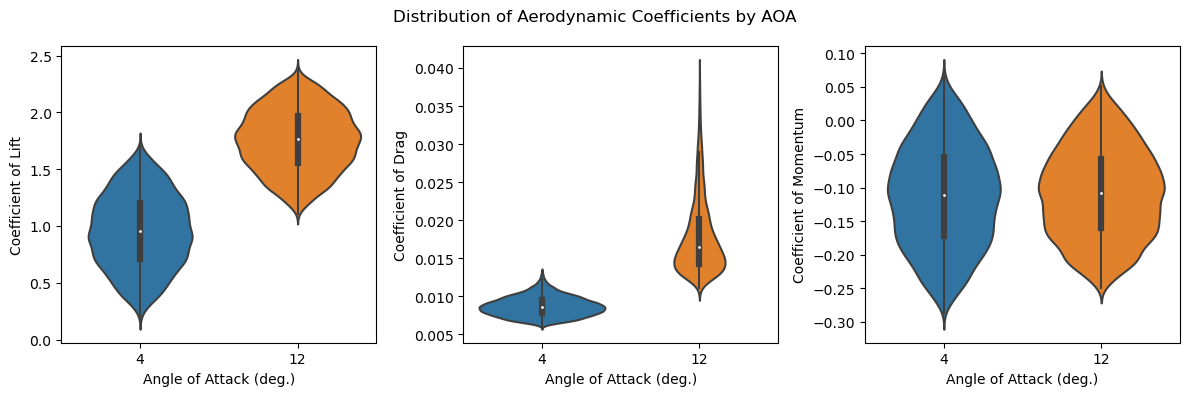

In [11]:
# Visualize distributions of coeffients of lift, drag, and moment as a function of angle of attack across all airfoils
with h5py.File(data_path, 'r') as hf:
        cl_alpha04 = hf['alpha+04']['C_l'][()]
        cd_alpha04 = hf['alpha+04']['C_d'][()]
        cm_alpha04 = hf['alpha+04']['C_m'][()]
        
        cl_alpha12 = hf['alpha+12']['C_l'][()]
        cd_alpha12 = hf['alpha+12']['C_d'][()]
        cm_alpha12 = hf['alpha+12']['C_m'][()]

plt.figure(figsize=(12, 4))

plt.subplot(131)
ax = sns.violinplot(data=[cl_alpha04, cl_alpha12])
ax.set_xticklabels([4,12])
plt.xlabel('Angle of Attack (deg.)')
plt.ylabel('Coefficient of Lift')

plt.subplot(132)
ax = sns.violinplot(data=[cd_alpha04, cd_alpha12])
ax.set_xticklabels([4,12])
plt.xlabel('Angle of Attack (deg.)')
plt.ylabel('Coefficient of Drag')

plt.subplot(133)
ax = sns.violinplot(data=[cm_alpha04, cm_alpha12])
ax.set_xticklabels([4,12])
plt.xlabel('Angle of Attack (deg.)')
plt.ylabel('Coefficient of Momentum')

plt.suptitle('Distribution of Aerodynamic Coefficients by AOA')
plt.tight_layout()
plt.show()

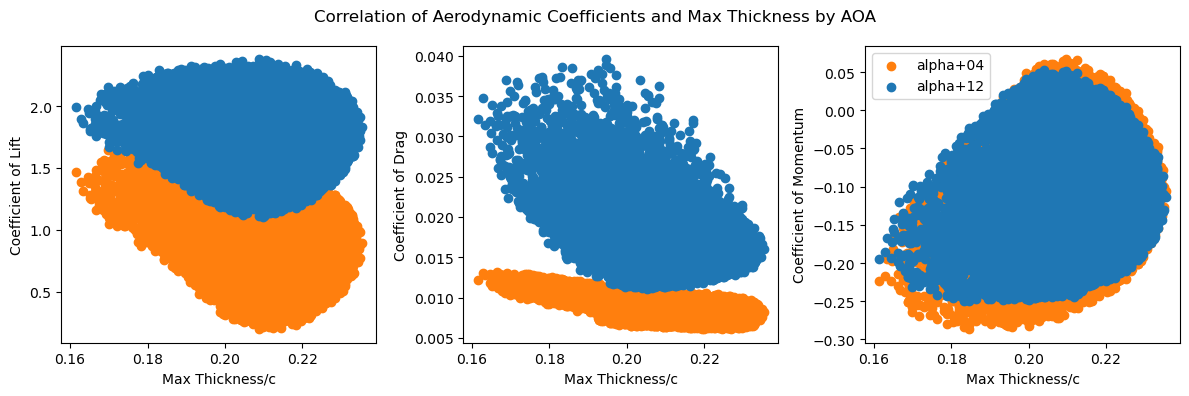

In [18]:
# Visualize distributions of coeffients of lift, drag, and moment as a function of angle of attack across all airfoils
with h5py.File(data_path, 'r') as hf:
        cl_alpha04 = hf['alpha+04']['C_l'][()]
        cd_alpha04 = hf['alpha+04']['C_d'][()]
        cm_alpha04 = hf['alpha+04']['C_m'][()]
        
        cl_alpha12 = hf['alpha+12']['C_l'][()]
        cd_alpha12 = hf['alpha+12']['C_d'][()]
        cm_alpha12 = hf['alpha+12']['C_m'][()]

plt.figure(figsize=(12, 4))

plt.subplot(131)
ax = plt.scatter(x=np.max(thickness_arr_2d, axis=1), y=cl_alpha04, c='tab:orange', label='alpha+04')
ax = plt.scatter(x=np.max(thickness_arr_2d, axis=1), y=cl_alpha12, c='tab:blue', label='alpha+12')
# ax.set_xticklabels([4,12])
plt.xlabel('Max Thickness/c')
plt.ylabel('Coefficient of Lift')

plt.subplot(132)
ax = plt.scatter(x=np.max(thickness_arr_2d, axis=1), y=cd_alpha04, c='tab:orange', label='alpha+04')
ax = plt.scatter(x=np.max(thickness_arr_2d, axis=1), y=cd_alpha12, c='tab:blue', label='alpha+12')
# ax.set_xticklabels([4,12])
plt.xlabel('Max Thickness/c')
plt.ylabel('Coefficient of Drag')

plt.subplot(133)
ax = plt.scatter(x=np.max(thickness_arr_2d, axis=1), y=cm_alpha04, c='tab:orange', label='alpha+04')
ax = plt.scatter(x=np.max(thickness_arr_2d, axis=1), y=cm_alpha12, c='tab:blue', label='alpha+12')
# ax.set_xticklabels([4,12])
plt.xlabel('Max Thickness/c')
plt.ylabel('Coefficient of Momentum')

plt.legend(loc='upper left')
plt.suptitle('Correlation of Aerodynamic Coefficients and Max Thickness by AOA')
plt.tight_layout()
plt.show()

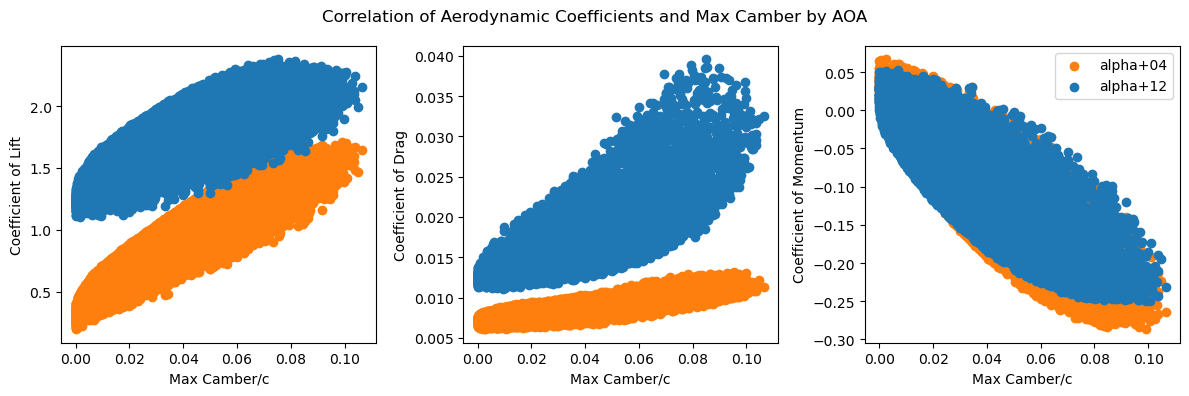

In [19]:
# Visualize distributions of coeffients of lift, drag, and moment as a function of angle of attack across all airfoils
with h5py.File(data_path, 'r') as hf:
        cl_alpha04 = hf['alpha+04']['C_l'][()]
        cd_alpha04 = hf['alpha+04']['C_d'][()]
        cm_alpha04 = hf['alpha+04']['C_m'][()]
        
        cl_alpha12 = hf['alpha+12']['C_l'][()]
        cd_alpha12 = hf['alpha+12']['C_d'][()]
        cm_alpha12 = hf['alpha+12']['C_m'][()]

plt.figure(figsize=(12, 4))

plt.subplot(131)
ax = plt.scatter(x=np.max(camber_arr_2d, axis=1), y=cl_alpha04, c='tab:orange', label='alpha+04')
ax = plt.scatter(x=np.max(camber_arr_2d, axis=1), y=cl_alpha12, c='tab:blue', label='alpha+12')
# ax.set_xticklabels([4,12])
plt.xlabel('Max Camber/c')
plt.ylabel('Coefficient of Lift')

plt.subplot(132)
ax = plt.scatter(x=np.max(camber_arr_2d, axis=1), y=cd_alpha04, c='tab:orange', label='alpha+04')
ax = plt.scatter(x=np.max(camber_arr_2d, axis=1), y=cd_alpha12, c='tab:blue', label='alpha+12')
# ax.set_xticklabels([4,12])
plt.xlabel('Max Camber/c')
plt.ylabel('Coefficient of Drag')

plt.subplot(133)
ax = plt.scatter(x=np.max(camber_arr_2d, axis=1), y=cm_alpha04, c='tab:orange', label='alpha+04')
ax = plt.scatter(x=np.max(camber_arr_2d, axis=1), y=cm_alpha12, c='tab:blue', label='alpha+12')
# ax.set_xticklabels([4,12])
plt.xlabel('Max Camber/c')
plt.ylabel('Coefficient of Momentum')

plt.suptitle('Correlation of Aerodynamic Coefficients and Max Camber by AOA')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [14]:
# Capture reduced dimensionality parameterizations as objects and print shapes
with h5py.File(data_path, 'r') as hf:
    bezier = hf['shape']['bezier'][()]
    print('Bezier')
    print(bezier.shape)
    
    cst = hf['shape']['cst'][()]
    print('CST')
    print(cst.shape)

    grassmann = hf['shape']['grassmann'][()]
    print('Grassmann')
    print(grassmann.shape)

Bezier
(8997, 15)
CST
(8997, 19)
Grassmann
(8997, 4)


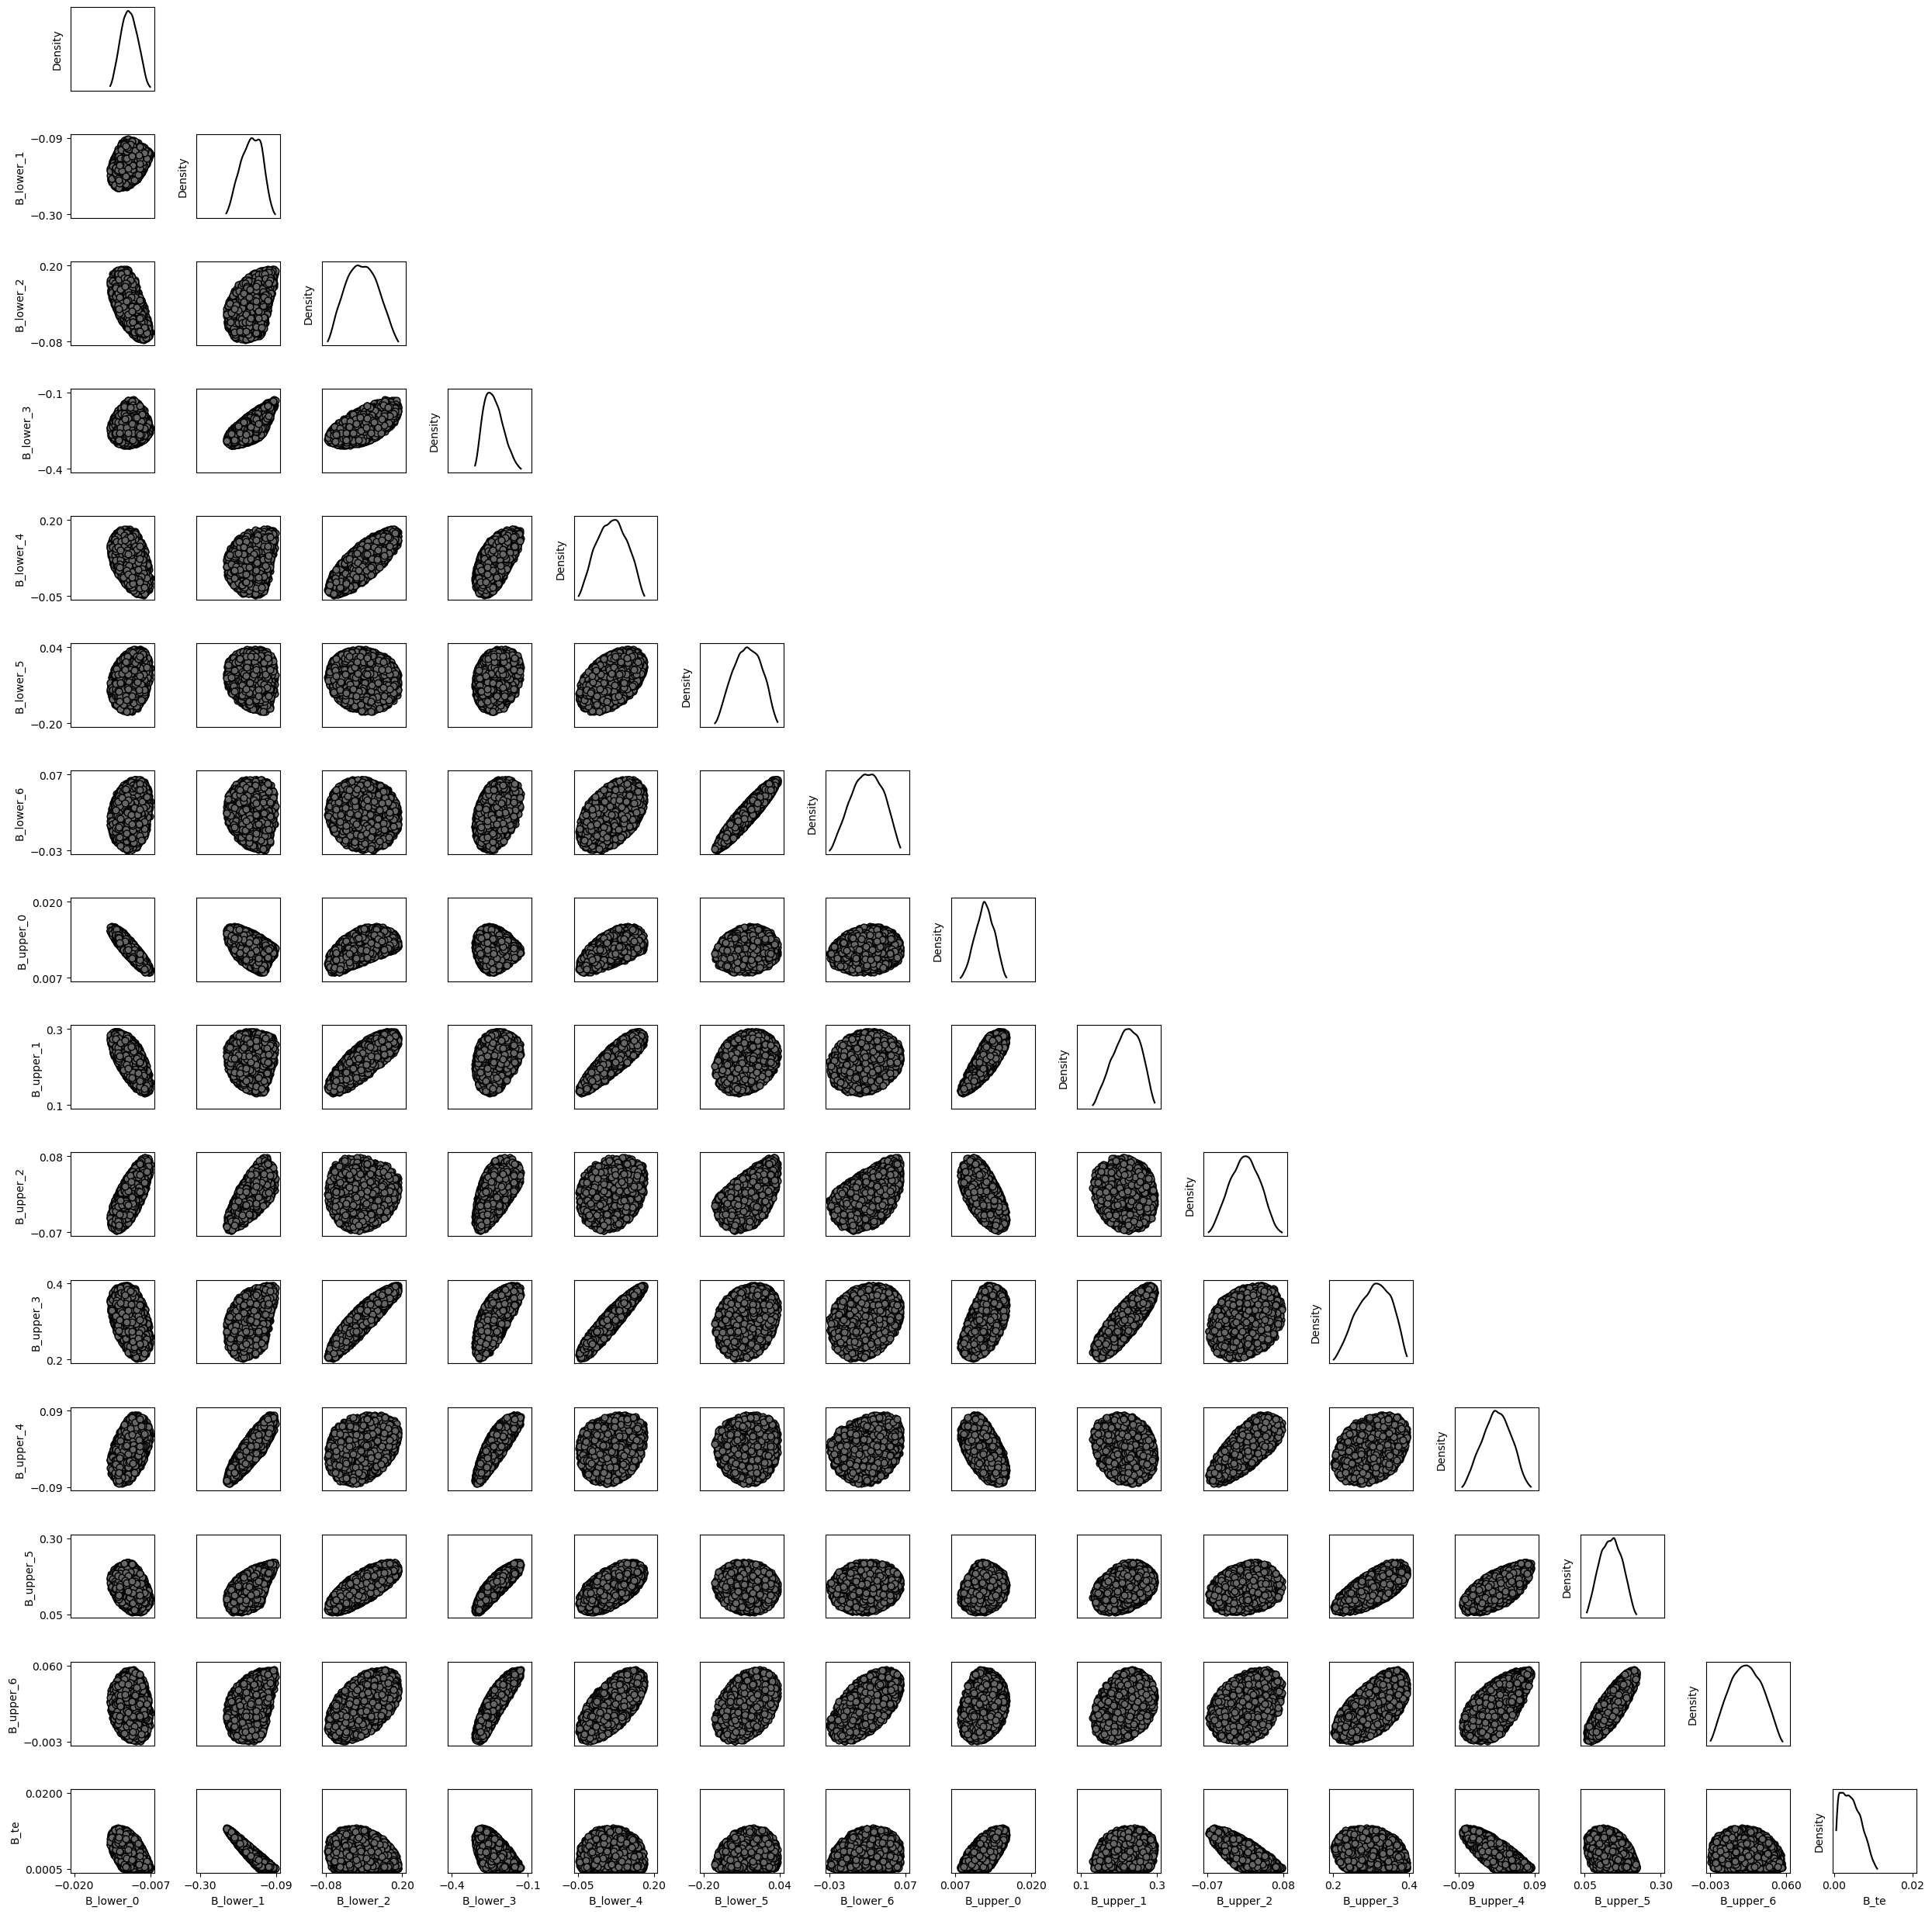

In [15]:
## Visualize distributions of Bezier curve parameters
# Capture number of parameters in bezier representation
m = bezier.shape[1]
# Create list to hold upper and lower limits for visualizations
bezier_limits = []
for i in range(m):
    # Capture min and max values in each bezier parameter across all airfoils
    lower = bezier[:,i].min()
    upper = bezier[:,i].max()
    # determine position of first non-zero digit after the decimal place, perform ceiling and floor rounding to that precision
    lower = rounders.floor(lower,(abs(int(math.log10(abs(lower))))+1))
    upper = rounders.ceil(upper,(abs(int(math.log10(abs(upper))))+1))
    # append parameter lower and upper limits to list
    bezier_limits.append([lower,upper])

# Create labels for bezier parameters
bezier_labels = ['B_lower_{}'.format(i) for i in range(int((m-1)/2))]
bezier_labels.extend(['B_upper_{}'.format(i) for i in range(int((m-1)/2))])
bezier_labels.extend(['B_te'])

# Plot marginal distributions of the bezier data
plt.figure(figsize=(25,25))
for i in range(m):
    for j in range(i+1):
        plt.subplot(m, m, (m*i)+j+1)
        if i == j:
            vals = np.linspace(bezier[:,i].min(), bezier[:,i].max())
            kde = gaussian_kde(bezier[:,i])
            plt.plot(vals,kde(vals),'k')
            plt.xlim(bezier_limits[i][0]-0.05*np.ptp(bezier_limits[i]),
                     bezier_limits[i][-1]+0.05*np.ptp(bezier_limits[i]))
            plt.yticks([])
            plt.ylabel('Density')
        
            if i == (m-1):
                plt.xlabel(bezier_labels[j], fontsize=10)
            else:
                plt.xticks([])

        else:
            plt.scatter(bezier[:,j], bezier[:,i], s=40, c=[[0.4,0.4,0.4]], edgecolor='k')
            plt.xticks(bezier_limits[j])
            plt.yticks(bezier_limits[i])
            
            if i == (m-1):
                plt.xlabel(bezier_labels[j], fontsize=10)
            else:
                plt.xticks([])
            if j == 0:
                plt.ylabel(bezier_labels[i], fontsize=10)
            else:
                plt.yticks([])
            plt.xlim(bezier_limits[j][0]-0.05*np.ptp(bezier_limits[j]), 
                     bezier_limits[j][-1]+0.05*np.ptp(bezier_limits[j]))
            plt.ylim(bezier_limits[i][0]-0.05*np.ptp(bezier_limits[i]), 
                     bezier_limits[i][-1]+0.05*np.ptp(bezier_limits[i]))

        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        plt.gca().set_aspect((xlim[1] - xlim[0])/(ylim[1] - ylim[0]))
        plt.tight_layout()
plt.show()


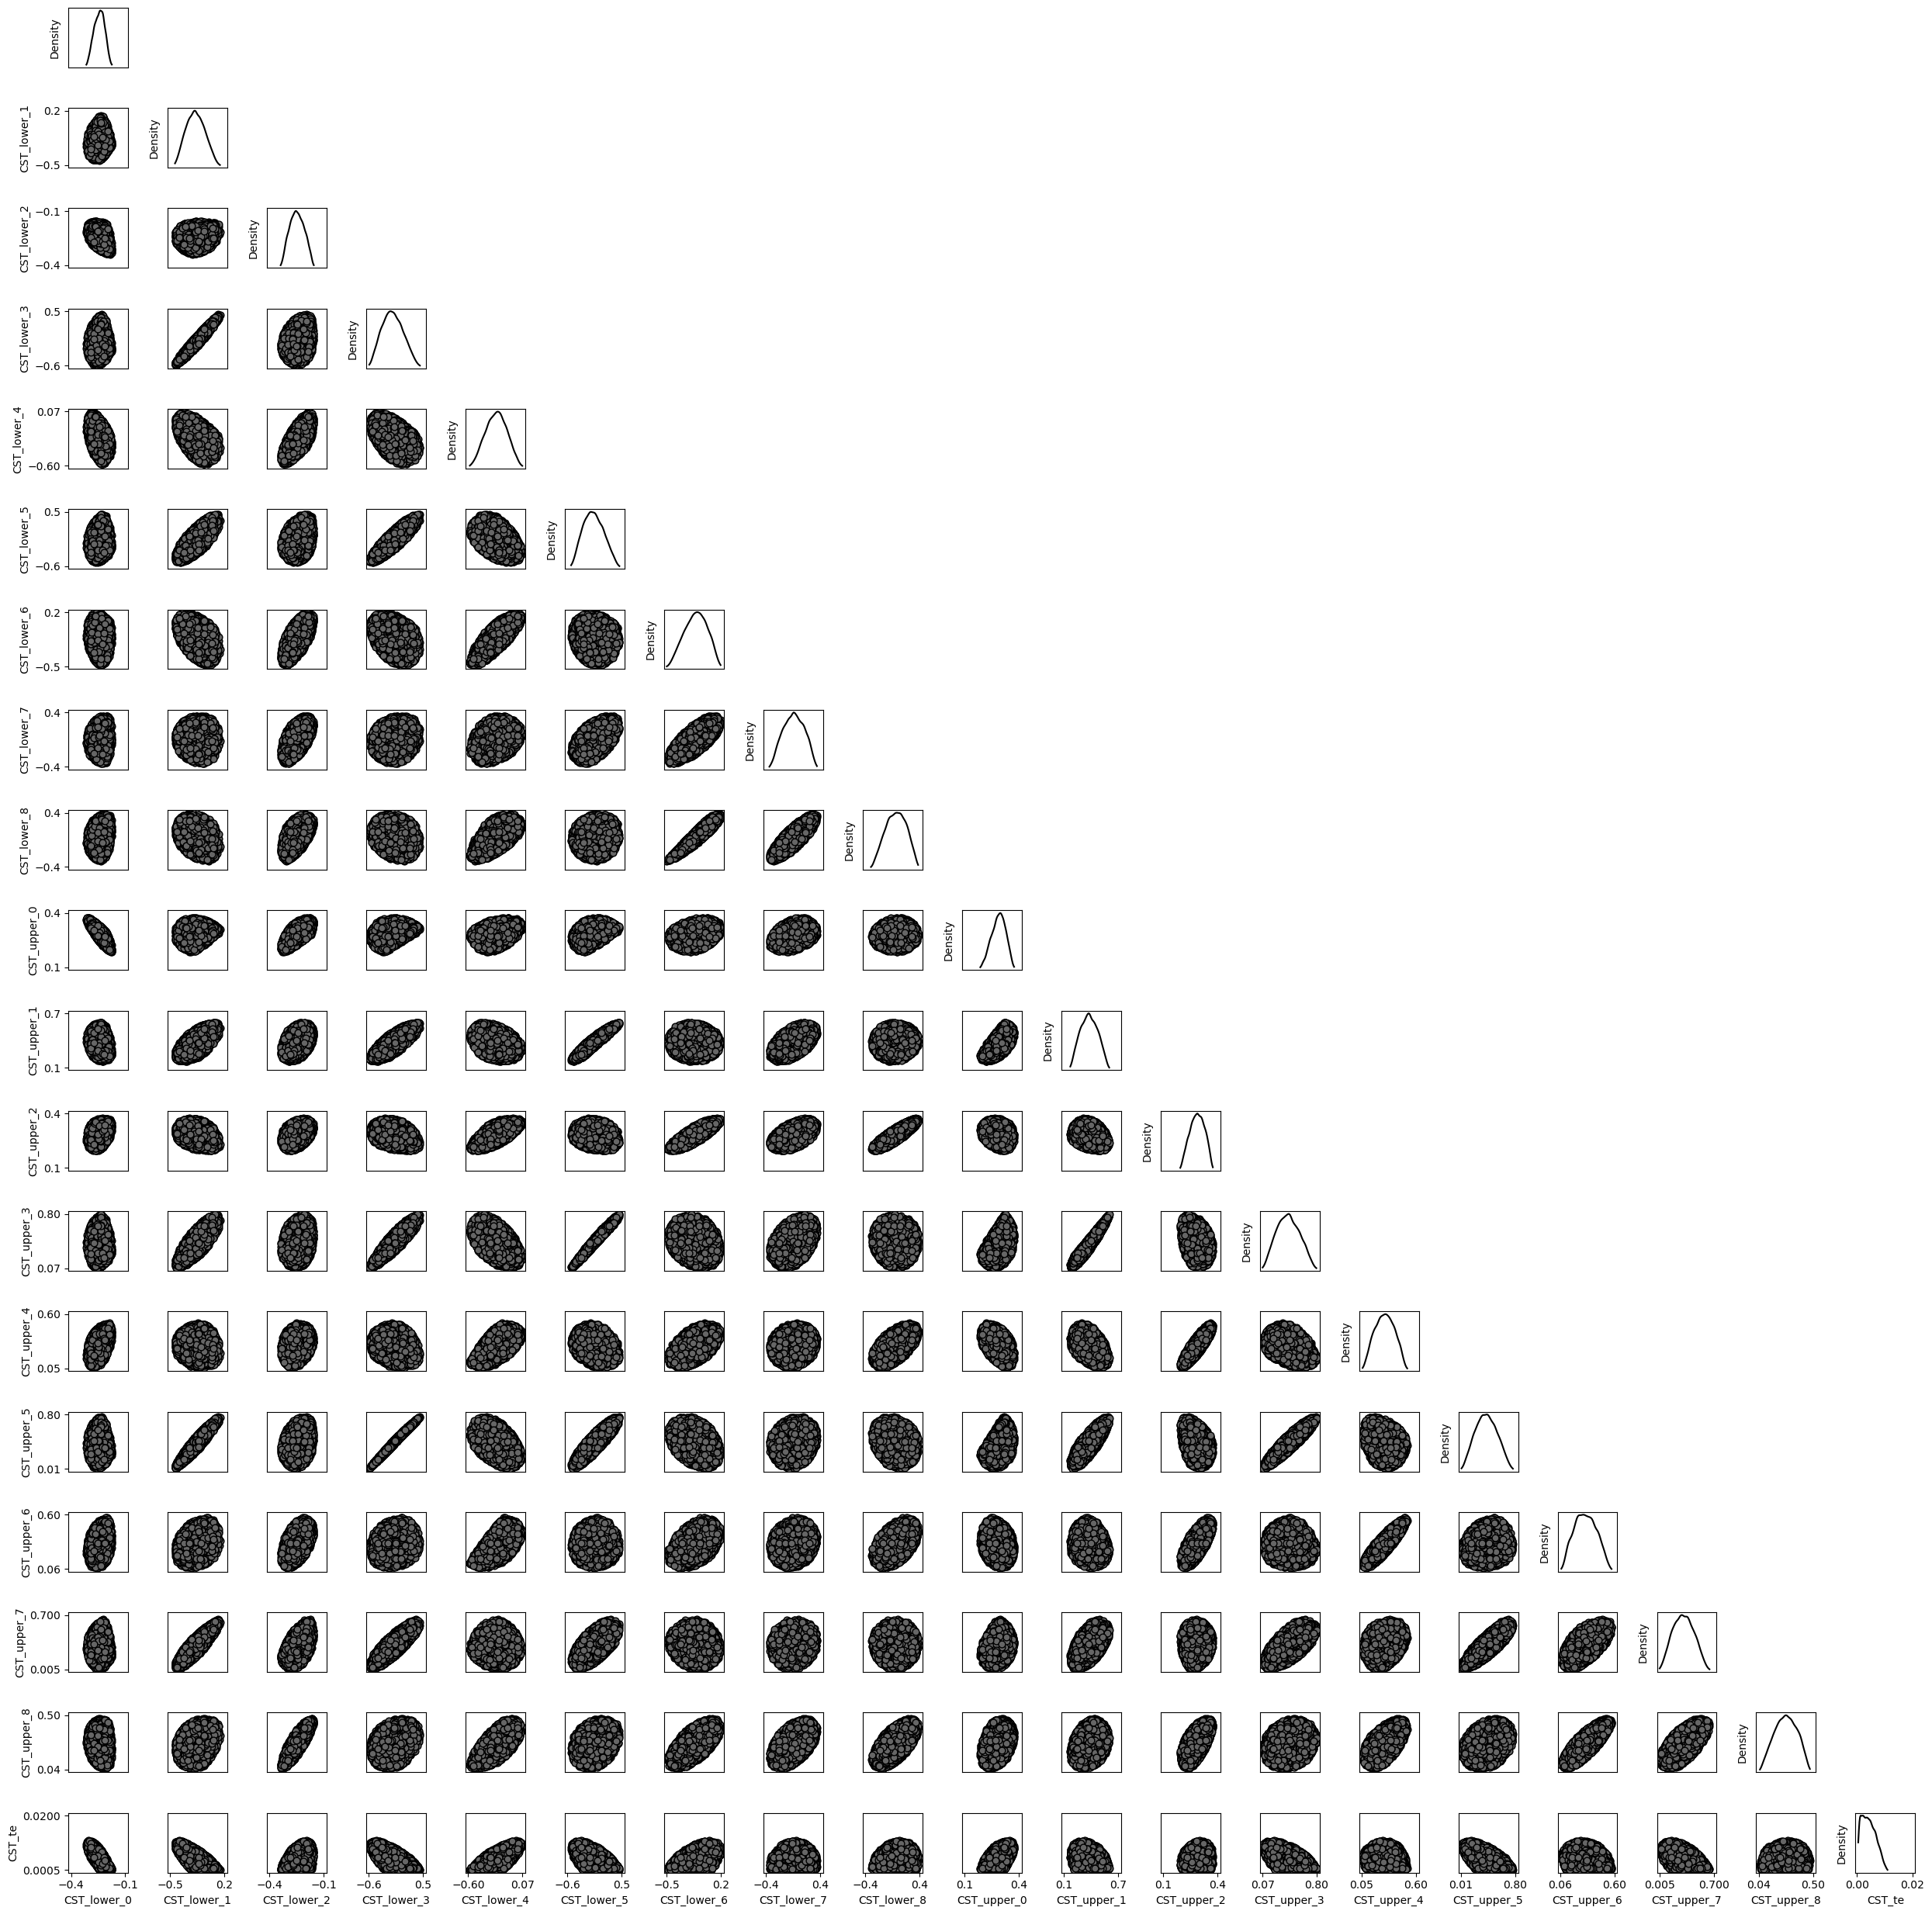

In [16]:
## Visualize distributions of CST parameters
# Capture number of parameters in CST representation
m = cst.shape[1]
# Create list to hold upper and lower limits for visualizations
cst_limits = []
for i in range(m):
    # Capture min and max values in each CST parameter across all airfoils
    lower = cst[:,i].min()
    upper = cst[:,i].max()
    # determine position of first non-zero digit after the decimal place, perform ceiling and floor rounding to that precision
    lower = rounders.floor(lower,(abs(int(math.log10(abs(lower))))+1))
    upper = rounders.ceil(upper,(abs(int(math.log10(abs(upper))))+1))
    # append parameter lower and upper limits to list
    cst_limits.append([lower,upper])

# Create labels for CST parameters
cst_labels = ['CST_lower_{}'.format(i) for i in range(int((m-1)/2))]
cst_labels.extend(['CST_upper_{}'.format(i) for i in range(int((m-1)/2))])
cst_labels.extend(['CST_te'])

# Plot marginal distributions of the CST data
plt.figure(figsize=(25,25))
for i in range(m):
    for j in range(i+1):
        plt.subplot(m, m, (m*i)+j+1)
        if i == j:
            vals = np.linspace(cst[:,i].min(), cst[:,i].max())
            kde = gaussian_kde(cst[:,i])
            plt.plot(vals,kde(vals),'k')
            plt.xlim(cst_limits[i][0]-0.05*np.ptp(cst_limits[i]),
                     cst_limits[i][-1]+0.05*np.ptp(cst_limits[i]))
            plt.yticks([])
            plt.ylabel('Density')
        
            if i == (m-1):
                plt.xlabel(cst_labels[j], fontsize=10)
            else:
                plt.xticks([])

        else:
            plt.scatter(cst[:,j], cst[:,i], s=40, c=[[0.4,0.4,0.4]], edgecolor='k')
            plt.xticks(cst_limits[j])
            plt.yticks(cst_limits[i])
            
            if i == (m-1):
                plt.xlabel(cst_labels[j], fontsize=10)
            else:
                plt.xticks([])
            if j == 0:
                plt.ylabel(cst_labels[i], fontsize=10)
            else:
                plt.yticks([])
            plt.xlim(cst_limits[j][0]-0.05*np.ptp(cst_limits[j]), 
                     cst_limits[j][-1]+0.05*np.ptp(cst_limits[j]))
            plt.ylim(cst_limits[i][0]-0.05*np.ptp(cst_limits[i]), 
                     cst_limits[i][-1]+0.05*np.ptp(cst_limits[i]))

        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        plt.gca().set_aspect((xlim[1] - xlim[0])/(ylim[1] - ylim[0]))
        plt.tight_layout()
plt.show()


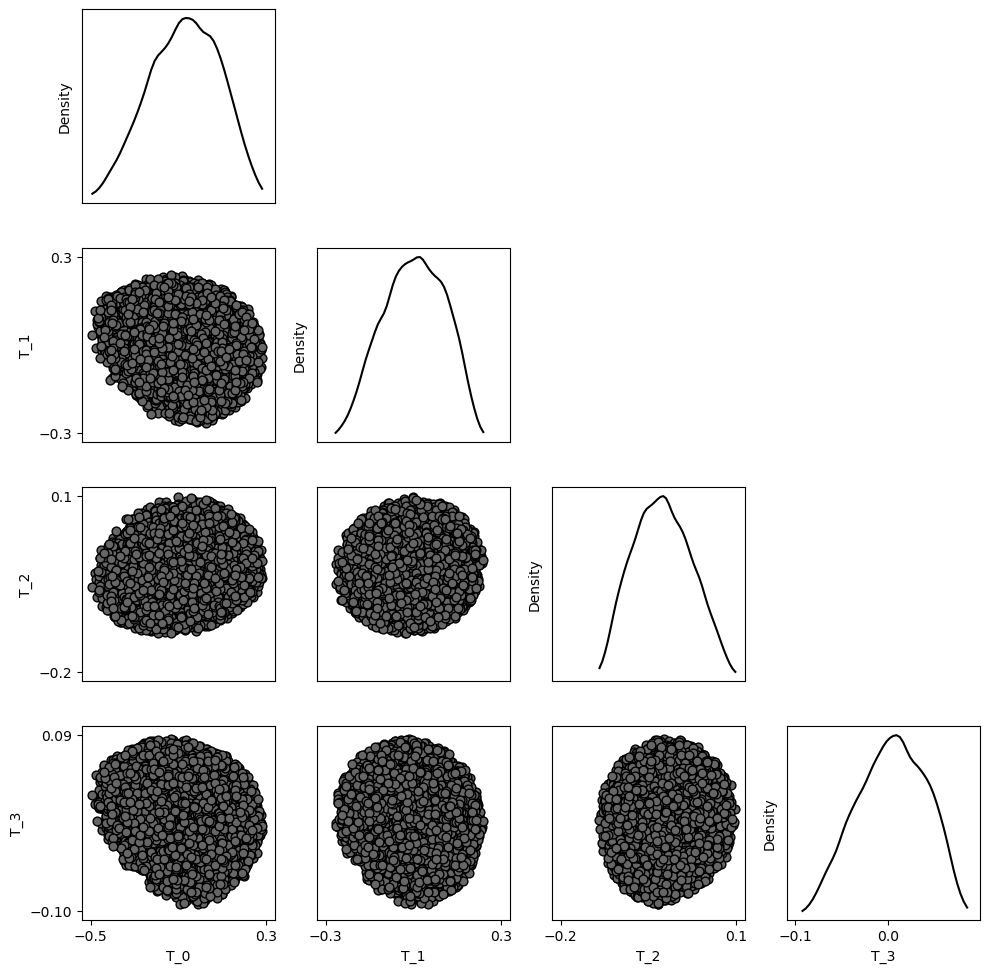

In [17]:
## Visualize distributions of Grassmann parameters
# Capture number of parameters in grassmann representation
m = grassmann.shape[1]
# Create list to hold upper and lower limits for visualizations
grassmann_limits = []
for i in range(m):
    # Capture min and max values in each grassmann parameter across all airfoils
    lower = grassmann[:,i].min()
    upper = grassmann[:,i].max()
    # determine position of first non-zero digit after the decimal place, perform ceiling and floor rounding to that precision
    lower = rounders.floor(lower,(abs(int(math.log10(abs(lower))))+1))
    upper = rounders.ceil(upper,(abs(int(math.log10(abs(upper))))+1))
    # append parameter lower and upper limits to list
    grassmann_limits.append([lower,upper])

# Create labels for grassmann parameters
grassmann_labels = ['T_{}'.format(i) for i in range(m)]

# Plot marginal distributions of the grassmann data
plt.figure(figsize=(10,10))
for i in range(m):
    for j in range(i+1):
        plt.subplot(m, m, (m*i)+j+1)
        if i == j:
            vals = np.linspace(grassmann[:,i].min(), grassmann[:,i].max())
            kde = gaussian_kde(grassmann[:,i])
            plt.plot(vals,kde(vals),'k')
            plt.xlim(grassmann_limits[i][0]-0.05*np.ptp(grassmann_limits[i]),
                     grassmann_limits[i][-1]+0.05*np.ptp(grassmann_limits[i]))
            plt.yticks([])
            plt.ylabel('Density')
        
            if i == (m-1):
                plt.xlabel(grassmann_labels[j], fontsize=10)
            else:
                plt.xticks([])

        else:
            plt.scatter(grassmann[:,j], grassmann[:,i], s=40, c=[[0.4,0.4,0.4]], edgecolor='k')
            plt.xticks(grassmann_limits[j])
            plt.yticks(grassmann_limits[i])
            
            if i == (m-1):
                plt.xlabel(grassmann_labels[j], fontsize=10)
            else:
                plt.xticks([])
            if j == 0:
                plt.ylabel(grassmann_labels[i], fontsize=10)
            else:
                plt.yticks([])
            plt.xlim(grassmann_limits[j][0]-0.05*np.ptp(grassmann_limits[j]), 
                     grassmann_limits[j][-1]+0.05*np.ptp(grassmann_limits[j]))
            plt.ylim(grassmann_limits[i][0]-0.05*np.ptp(grassmann_limits[i]), 
                     grassmann_limits[i][-1]+0.05*np.ptp(grassmann_limits[i]))

        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        plt.gca().set_aspect((xlim[1] - xlim[0])/(ylim[1] - ylim[0]))
        plt.tight_layout()
plt.show()
